# **Teacher Model Setup**

## 📦 Install Required Dependencies
Before running our model, we need to ensure all the required Python packages are installed.  
Here we install **PyTorch**, **Torchvision**, **timm** (for EfficientNet), **tqdm** (progress bars), and **Matplotlib** for visualization.


In [ ]:
# Install dependencies (if not installed)
!pip install torch torchvision timm tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 📚 Import Libraries
We start by importing all the essential libraries for our pipeline, including:
- **PyTorch** for building and training deep learning models  
- **Torchvision** for datasets and image transformations  
- **timm** for pre-trained EfficientNet models  
- **Matplotlib & NumPy** for data handling and visualization  
- **tqdm** for progress bars during training


In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import timm  # For EfficientNet
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

## 🖼 Data Transformations
To prepare our dataset for training, we:
- Resize all images to **224×224 pixels** (EfficientNet input size)  
- Convert images to **PyTorch tensors**  
- Normalize pixel values to help the model converge faster.


In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match EfficientNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for better training
])

## 📂 Load Dataset
We load the dataset from our Google Drive path using `ImageFolder`,  
which automatically assigns labels based on folder names.


In [ ]:
# Load dataset
dataset_path = "/content/drive/MyDrive/Dataset For Research"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

## ✂ Dataset Splitting (Initial Approach)
We define the dataset size and split it into:
- **80% Training**
- **10% Validation**
- **10% Testing**

This ensures separate data for training, tuning, and final evaluation.


In [ ]:
from torch.utils.data import random_split, DataLoader

# Assuming `full_dataset` is already defined
dataset_size = len(dataset)
train_size = int(0.80 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size  # Remaining 25%

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## 🎯 Access Original Dataset Labels
We retrieve the **original dataset object** and extract its labels (targets),  
which we will use later to create balanced splits.


In [ ]:
# Get the original dataset (assuming train_dataset is a Subset of the original dataset)
original_dataset = train_dataset.dataset  # This gets the full dataset before any splitting

# Get labels from the original dataset
targets = np.array(original_dataset.targets)  # Assuming it's a standard torchvision dataset


## 🔍 Identify Classes and Indices
Here, we determine:
- The **number of classes**
- The **indices** of images belonging to each class  
This will help us split the data evenly.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Find unique classes
num_classes = len(set(targets))

# Store indices for each class
class_indices = {cls: np.where(targets == cls)[0] for cls in range(num_classes)}


## ⚖ Balanced Dataset Splitting
Instead of random splitting, we ensure **class balance**:
- Each class is split into **80% train, 10% validation, 10% test**
- We shuffle the indices to avoid order bias.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Get labels of the dataset
labels = np.array(original_dataset.targets)  # Assuming original_dataset follows torchvision Dataset format
num_classes = len(set(labels))

# Store indices for train, validation, and test
train_idx, val_idx, test_idx = [], [], []

# Process each class separately to ensure balanced splits
for class_label in range(num_classes):
    class_indices = np.where(labels == class_label)[0]  # Get indices of this class

    # Split class indices into 80% train, 10% validation, 10% test
    train_split, temp_split = train_test_split(class_indices, test_size=0.20, random_state=42)
    val_split, test_split = train_test_split(temp_split, test_size=0.50, random_state=42)

    # Append indices to respective lists
    train_idx.extend(train_split)
    val_idx.extend(val_split)
    test_idx.extend(test_split)

# Shuffle to mix different classes
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

## 🗂 Create Final Train, Validation, and Test Datasets
We use the balanced indices to create final subsets  
for training, validation, and testing.


In [ ]:
from torch.utils.data import Subset

train_dataset_final = Subset(original_dataset, train_idx)
val_dataset_final = Subset(original_dataset, val_idx)
test_dataset_final = Subset(original_dataset, test_idx)


## 📥 Create Data Loaders
We wrap our datasets in **DataLoader** objects to:
- Load data in batches (batch size = 32)  
- Shuffle training data for randomness  
- Keep validation & test data in fixed order.


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset_final, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset_final, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset_final, batch_size=32, shuffle=False)


## 📊 Dataset Summary
We print the number of images in each split to verify  
that our splitting process worked correctly.


In [ ]:
print(f"Training samples: {len(train_dataset_final)}")
print(f"Validation samples: {len(val_dataset_final)}")
print(f"Testing samples: {len(test_dataset_final)}")

Training samples: 2880
Validation samples: 360
Testing samples: 360


## 📈 Class Distribution Check
We print how many samples each class has in the **train**, **validation**, and **test** sets.  
This helps us confirm that the splits are balanced.


In [ ]:
from collections import Counter
import numpy as np

# Convert original dataset targets to numpy array
targets = np.array(original_dataset.targets)

# Function to count class distribution
def count_class_samples(dataset, dataset_name):
    indices = dataset.indices  # Get the indices of the subset
    class_counts = Counter(targets[indices])  # Count occurrences of each class

    print(f"\n{dataset_name} Set Distribution:")
    for cls, count in sorted(class_counts.items()):
        print(f"Class {cls}: {count} samples")

# Print distribution for each dataset
count_class_samples(train_dataset_final, "Training")
count_class_samples(val_dataset_final, "Validation")
count_class_samples(test_dataset_final, "Testing")



Training Set Distribution:
Class 0: 320 samples
Class 1: 320 samples
Class 2: 320 samples
Class 3: 320 samples
Class 4: 320 samples
Class 5: 320 samples
Class 6: 320 samples
Class 7: 320 samples
Class 8: 320 samples

Validation Set Distribution:
Class 0: 40 samples
Class 1: 40 samples
Class 2: 40 samples
Class 3: 40 samples
Class 4: 40 samples
Class 5: 40 samples
Class 6: 40 samples
Class 7: 40 samples
Class 8: 40 samples

Testing Set Distribution:
Class 0: 40 samples
Class 1: 40 samples
Class 2: 40 samples
Class 3: 40 samples
Class 4: 40 samples
Class 5: 40 samples
Class 6: 40 samples
Class 7: 40 samples
Class 8: 40 samples


## 🏫 Define the Teacher Model (EfficientNet-B3)
We create a custom class for our **teacher model** using `timm`:
- Load a pre-trained **EfficientNet-B3** model
- Replace the last classification layer to match our dataset's number of classes


In [ ]:
# Define the Teacher Model (EfficientNet-B3)
class TeacherModel(nn.Module):
    def __init__(self, num_classes):
        super(TeacherModel, self).__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)  # Modify last layer

    def forward(self, x):
        return self.model(x)

## ⚙ Initialize the Teacher Model
We instantiate our teacher model and move it to **GPU** for faster training.


In [ ]:
# Initialize Teacher Model
num_classes = len(dataset.classes)  # Get number of classes from dataset
teacher_model = TeacherModel(num_classes).cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

## 🏗 Model Summary
We print the architecture of our teacher model to confirm  
that the final layer has been updated for our dataset.


In [ ]:
# Print Model Summary
print(teacher_model)

TeacherModel(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

## 🎓 Training Function for Teacher Model
We define the `train_teacher()` function:
- Uses **CrossEntropyLoss** and **Adam optimizer**
- Trains the model for given epochs
- Tracks training loss & accuracy
- Validates after each epoch
- Saves the best model based on validation accuracy


In [ ]:
# Define Training Function with Accuracy & Loss Tracking
def train_teacher(model, train_loader, val_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0  # Track best validation accuracy

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Iterate through batches
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Track total loss
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        # Calculate loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc = evaluate_teacher(model, val_loader)

        print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "teacher_model.pth")
            print("✅ Saved Best Model!")

## 📏 Evaluation Function for Teacher Model
We define `evaluate_teacher()` to:
- Run the model in evaluation mode
- Calculate and return the **validation accuracy**


In [ ]:
# Function to Evaluate Teacher Model
def evaluate_teacher(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total  # Return validation accuracy

## 🚀 Train the Teacher Model
We train the **EfficientNet-B3** teacher model for 10 epochs  
using our training and validation datasets.


In [ ]:
# Train Teacher Model (EfficientNet-B3)
train_teacher(teacher_model, train_dataloader, val_dataloader, epochs=10)

Epoch 1/10: 100%|██████████| 90/90 [26:43<00:00, 17.82s/it]


Epoch 1: Loss=0.4083, Train Acc=87.81%, Val Acc=95.83%
✅ Saved Best Model!


Epoch 2/10: 100%|██████████| 90/90 [02:16<00:00,  1.52s/it]


Epoch 2: Loss=0.1061, Train Acc=96.74%, Val Acc=96.94%
✅ Saved Best Model!


Epoch 3/10: 100%|██████████| 90/90 [02:17<00:00,  1.53s/it]


Epoch 3: Loss=0.0369, Train Acc=98.72%, Val Acc=96.11%


Epoch 4/10: 100%|██████████| 90/90 [02:26<00:00,  1.63s/it]


Epoch 4: Loss=0.0550, Train Acc=98.33%, Val Acc=97.50%
✅ Saved Best Model!


Epoch 5/10: 100%|██████████| 90/90 [02:23<00:00,  1.59s/it]


Epoch 5: Loss=0.0365, Train Acc=98.75%, Val Acc=98.06%
✅ Saved Best Model!


Epoch 6/10: 100%|██████████| 90/90 [02:23<00:00,  1.59s/it]


Epoch 6: Loss=0.0268, Train Acc=99.41%, Val Acc=99.17%
✅ Saved Best Model!


Epoch 7/10: 100%|██████████| 90/90 [02:23<00:00,  1.59s/it]


Epoch 7: Loss=0.0189, Train Acc=99.51%, Val Acc=98.33%


Epoch 8/10: 100%|██████████| 90/90 [02:22<00:00,  1.58s/it]


Epoch 8: Loss=0.0340, Train Acc=99.24%, Val Acc=96.39%


Epoch 9/10: 100%|██████████| 90/90 [02:23<00:00,  1.60s/it]


Epoch 9: Loss=0.0713, Train Acc=97.99%, Val Acc=96.94%


Epoch 10/10: 100%|██████████| 90/90 [02:23<00:00,  1.59s/it]


Epoch 10: Loss=0.0386, Train Acc=99.10%, Val Acc=98.33%


## 📊 Model Testing Function
We define a function to:
- Test the trained model on the **test set**
- Calculate accuracy, precision, recall, and F1-score
- Show a **confusion matrix** for visualizing performance per class


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def test_model(model, test_dataloader, class_names, device):
    """
    Evaluate the model on the test dataset.

    - Computes Accuracy, Precision, Recall, and F1-score.
    - Displays the Confusion Matrix.
    """
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # No gradient calculation needed
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the class index with the highest probability

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    print(f"Test Accuracy: {accuracy:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


## 📂 Load Trained Model & Class Names
We load the best saved teacher model weights  
and define the list of **class names** for display in the confusion matrix.


In [ ]:
# Load the trained model (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.load_state_dict(torch.load("/content/teacher_model.pth", map_location=device))
teacher_model.to(device)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature Granulocyte',
               'Lymphocyte', 'Monocyte', 'Myeloblast', 'Neutrophil', 'Promyelocyte']

## 🧪 Test the Teacher Model
We evaluate the model on the **test dataset**  
and print classification metrics with a confusion matrix.


In [ ]:
# Call the test function
test_model(teacher_model, test_dataloader, class_names, device=device)

## 📊 Alternative Testing with Detailed Metrics
This version of the testing function:
- Computes accuracy, precision, recall, F1-score (macro average)
- Prints a full classification report
- Displays the confusion matrix


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.load_state_dict(torch.load("/content/teacher_model.pth", map_location=device))
teacher_model.to(device)
teacher_model.eval()  # Set model to evaluation mode

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature Granulocyte',
               'Lymphocyte', 'Monocyte', 'Myeloblast', 'Neutrophil', 'Promyelocyte']

# Define the test function
def test_model(model, dataloader, class_names, device):
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute overall metrics
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision = precision_score(y_true, y_pred, average='macro')
    overall_recall = recall_score(y_true, y_pred, average='macro')
    overall_f1 = f1_score(y_true, y_pred, average='macro')

    # Print overall results
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    # Compute and plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


<ipython-input-22-ca83b2a609ad>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("/content/teacher_model.pth", map_location=device)

## 🧪 Run the Detailed Test
We call our alternative `test_model()` function  
to see detailed metrics and confusion matrix visualization.


Overall Accuracy: 0.9861
Overall Precision: 0.9864
Overall Recall: 0.9861
Overall F1 Score: 0.9861

Classification Report:
                       precision    recall  f1-score   support

            Basophil       1.00      1.00      1.00        40
          Eosinophil       1.00      1.00      1.00        40
        Erythroblast       0.98      1.00      0.99        40
Immature Granulocyte       0.97      0.97      0.97        40
          Lymphocyte       1.00      0.97      0.99        40
            Monocyte       1.00      0.97      0.99        40
          Myeloblast       0.95      0.97      0.96        40
          Neutrophil       0.98      1.00      0.99        40
        Promyelocyte       1.00      0.97      0.99        40

            accuracy                           0.99       360
           macro avg       0.99      0.99      0.99       360
        weighted avg       0.99      0.99      0.99       360



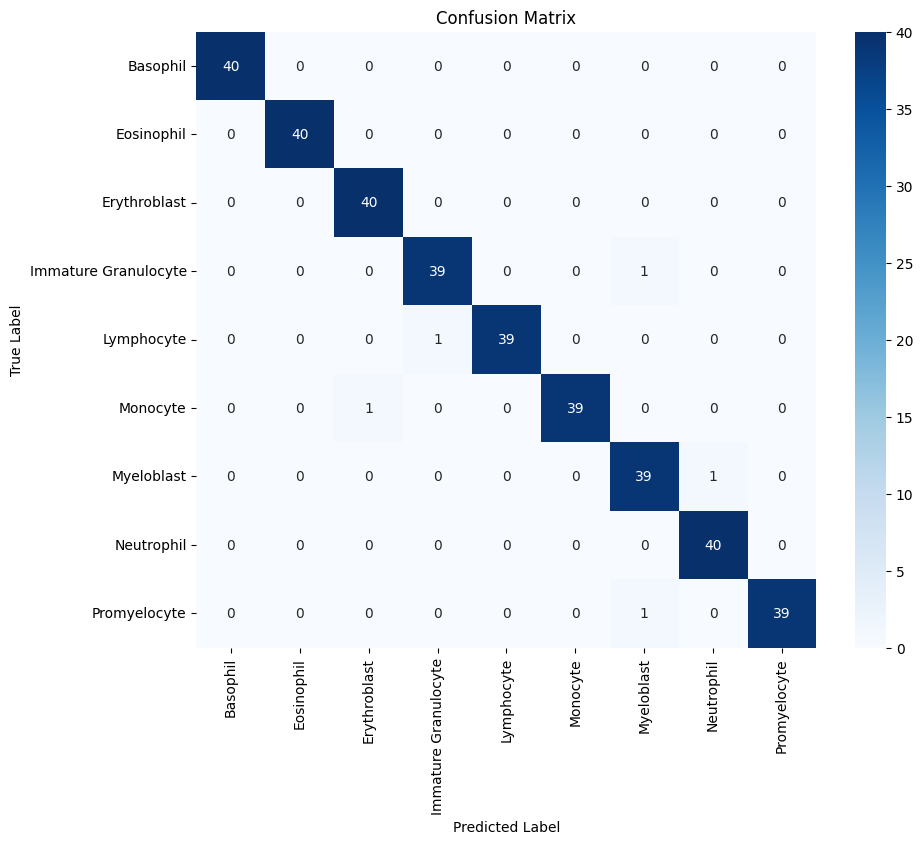

In [ ]:
# Call the test function
test_model(teacher_model, test_dataloader, class_names, device=device)


## 🔎 Check for Data Leakage
We extract the file paths in train, validation, and test sets  
and ensure **no overlap** between them.


In [ ]:
# Extract file names based on dataset indices
train_files = set([original_dataset.imgs[i][0] for i in train_idx])
val_files = set([original_dataset.imgs[i][0] for i in val_idx])
test_files = set([original_dataset.imgs[i][0] for i in test_idx])

# Check for overlap
common_train_val = train_files.intersection(val_files)
common_train_test = train_files.intersection(test_files)
common_val_test = val_files.intersection(test_files)

print(f"Common files between train and val: {len(common_train_val)}")
print(f"Common files between train and test: {len(common_train_test)}")
print(f"Common files between val and test: {len(common_val_test)}")


Common files between train and val: 0
Common files between train and test: 0
Common files between val and test: 0


## 📑 Check Label Coverage in Splits
We verify that all classes are represented in each split,  
ensuring no missing categories in training, validation, or testing.


In [ ]:
# Extract labels for each split
train_labels = set([original_dataset.targets[i] for i in train_idx])
val_labels = set([original_dataset.targets[i] for i in val_idx])
test_labels = set([original_dataset.targets[i] for i in test_idx])

# Check if labels are properly distributed (not a leakage, but an imbalance check)
print(f"Train labels: {train_labels}")
print(f"Validation labels: {val_labels}")
print(f"Test labels: {test_labels}")


Train labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Validation labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Test labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}


# **Student Model Setup**

## 📦 Installing Dependencies
We begin by installing the required Python packages for our project.  
- **PyTorch & Torchvision** – For deep learning model creation and pre-trained architectures  
- **Torchsummary** – To view a detailed model summary  
- **Timm** – PyTorch Image Models library with modern architectures  
- **Matplotlib** – For static visualizations  


In [ ]:
!pip install torch torchvision torchsummary timm matplotlib

## 📚 Importing Libraries
Here we import the core Python packages and modules we’ll need:  
- **PyTorch** for deep learning  
- **Torchvision Models** for pre-trained backbones  
- **NumPy** for numerical operations  
- **TQDM** for progress bars during training  
- **Sklearn Metrics** for evaluation (precision, recall, F1, confusion matrix)  
- **Seaborn & Matplotlib** for creating visually appealing plots  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from torchvision import models
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## 🔍 Squeeze-and-Excitation Block
We define a **Squeeze-and-Excitation (SE) Block**, which adaptively recalibrates channel-wise feature responses.  
- Performs **Global Average Pooling** to squeeze spatial info into a channel descriptor  
- Learns **channel importance weights** via two fully connected layers  
- Multiplies input feature maps by learned weights to boost important channels and suppress less useful ones  


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        squeeze = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1, 1)
        return x * excitation


## 🧠 Defining TinyResNet (Student Model)
We create a compact **ResNet-18-based student model**:  
- Loads a **pre-trained ResNet-18** as a backbone  
- Replaces the final fully connected layer to output predictions for **9 classes**  
- Adds **Dropout** to reduce overfitting  
This lightweight architecture will learn from the Teacher Model using knowledge distillation.  


In [ ]:
class TinyResNet(nn.Module):
    def __init__(self, num_classes=9):
        super(TinyResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # Add dropout for regularization
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.resnet(x)
        return self.dropout(x)


## 🔄 MFFA-KD: Multi-Feature Fusion with Knowledge Distillation
We wrap both **Teacher** and **Student** models inside a single module:  
- Extract intermediate feature maps  
- Use **SE attention blocks** to enhance important features at different layers  
- Fuse multi-scale features via a 1×1 convolution  
- Apply **Knowledge Distillation Loss** (KL Divergence) between teacher and student predictions with temperature scaling  


In [ ]:
class MFFA_KD(nn.Module):
    def __init__(self, teacher_model, student_model, alpha=0.5, temperature=7):
        super(MFFA_KD, self).__init__()
        self.teacher = teacher_model
        self.student = student_model
        self.alpha = alpha
        self.temperature = temperature

        # Feature fusion layers with SE blocks
        self.attn1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(), SEBlock(64))
        self.attn2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=1), nn.ReLU(), SEBlock(128))
        self.attn3 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=1), nn.ReLU(), SEBlock(256))

        self.fusion = nn.Conv2d(448, 256, kernel_size=1)

        # Loss function
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, x):
        with torch.no_grad():
            teacher_out = self.teacher(x)

        student_out = self.student(x)

        # Soft targets
        soft_targets = F.log_softmax(student_out / self.temperature, dim=1)
        teacher_probs = F.softmax(teacher_out / self.temperature, dim=1)

        # KD loss
        kd_loss = self.kl_loss(soft_targets, teacher_probs)

        return student_out, kd_loss


## 🎓 Loading Pre-Trained Teacher Model
We initialize the teacher model and load its **pre-trained weights** from disk.  
The teacher has been trained on the same dataset and will guide the student model via soft label supervision.  


In [ ]:
teacher_model = TeacherModel(num_classes).cuda()  # Use your model class
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/Dataset For Research/teacher_model.pth"))
teacher_model.eval()  # Set to evaluation mode

<ipython-input-25-e320ddb80361>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/Dataset For Research/teache

TeacherModel(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

## 🧑‍🎓 Initializing the Student Model
We create an instance of our **TinyResNet** student model and move it to the GPU for accelerated training.  


In [ ]:
# Initialize TinyResNet student
student_model = TinyResNet(num_classes=9).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


## 🔗 Wrapping Teacher & Student into MFFA-KD
We combine the teacher and student into our **MFFA-KD framework**, enabling joint forward passes and KD loss computation.  


In [ ]:
# Wrap with MFFA-KD
kd_model = MFFA_KD(teacher_model, student_model).to(device)


## 🏋️ Training the Student Model with Knowledge Distillation
We define a training function that:  
1. Uses **CrossEntropy Loss** with label smoothing for stable learning  
2. Uses **Cyclic Learning Rate Scheduler** for dynamic learning rates  
3. Computes total loss as a mix of classification loss and KD loss  
4. Tracks training and validation accuracy each epoch  
5. Saves the **best model checkpoint** based on validation accuracy  


In [ ]:
def train_student(model, train_loader, val_loader, optimizer, num_epochs=10, device="cuda", save_path="best_student_kd.pth"):
    best_acc = 0.0
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=5, mode='triangular2')

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, kd_loss = model(inputs)

            loss = (1 - model.alpha) * criterion(outputs, labels) + model.alpha * kd_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total

        print(f"Epoch {epoch}: Loss={running_loss / len(train_loader):.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved Best Model!")


## ⚙️ Optimizer Configuration
We use **AdamW** optimizer with weight decay for better generalization and stable training of our KD model.  


In [ ]:
optimizer = optim.AdamW(kd_model.parameters(), lr=1e-3, weight_decay=1e-4)

## 🚀 Starting the Training Process
We now train the MFFA-KD framework for 10 epochs using the training and validation datasets.  


In [ ]:
train_student(kd_model, train_dataloader, val_dataloader, optimizer, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 90/90 [27:45<00:00, 18.51s/it]


Epoch 1: Loss=0.8059, Train Acc=60.45%, Val Acc=96.11%
✅ Saved Best Model!


Epoch 2/10: 100%|██████████| 90/90 [02:04<00:00,  1.38s/it]


Epoch 2: Loss=0.6903, Train Acc=67.85%, Val Acc=97.22%
✅ Saved Best Model!


Epoch 3/10: 100%|██████████| 90/90 [02:03<00:00,  1.37s/it]


Epoch 3: Loss=0.6804, Train Acc=68.92%, Val Acc=97.22%


Epoch 4/10: 100%|██████████| 90/90 [02:01<00:00,  1.36s/it]


Epoch 4: Loss=0.6787, Train Acc=68.54%, Val Acc=98.06%
✅ Saved Best Model!


Epoch 5/10: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


Epoch 5: Loss=0.6626, Train Acc=70.24%, Val Acc=98.06%


Epoch 6/10: 100%|██████████| 90/90 [02:00<00:00,  1.34s/it]


Epoch 6: Loss=0.6537, Train Acc=70.38%, Val Acc=98.06%


Epoch 7/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it]


Epoch 7: Loss=0.6580, Train Acc=70.17%, Val Acc=98.61%
✅ Saved Best Model!


Epoch 8/10: 100%|██████████| 90/90 [02:03<00:00,  1.37s/it]


Epoch 8: Loss=0.6425, Train Acc=72.08%, Val Acc=98.33%


Epoch 9/10: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


Epoch 9: Loss=0.6481, Train Acc=70.66%, Val Acc=98.33%


Epoch 10/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it]


Epoch 10: Loss=0.6437, Train Acc=70.10%, Val Acc=98.61%


## 🧪 Evaluating the Student Model
This function:  
- Runs inference on the **test dataset**  
- Calculates **Accuracy, Precision, Recall, and F1-Score**  
- Displays a **classification report**  
- Plots a **confusion matrix** to visualize class-level performance  


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def test_student(model, test_loader, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"📊 Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    print("\n🔹 Classification Report:\n", classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

## 📊 Testing the Student Model
We call the `test_student()` function to evaluate the trained student model on the test set.  


Test Accuracy: 98.33%
📊 Precision: 0.9837, Recall: 0.9833, F1-score: 0.9834

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.95      0.97        40
           2       0.98      1.00      0.99        40
           3       0.98      1.00      0.99        40
           4       0.95      0.97      0.96        40
           5       1.00      0.97      0.99        40
           6       1.00      0.97      0.99        40
           7       0.95      0.97      0.96        40
           8       1.00      1.00      1.00        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



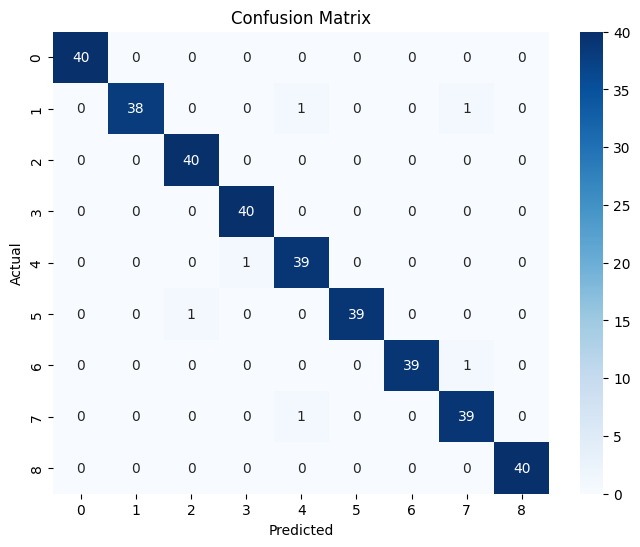

In [ ]:
test_student(kd_model, test_dataloader, device=device)

## 📦 Installing Visualization Libraries
Here we install extra libraries (Matplotlib, NumPy, Seaborn) for better result visualizations.  


In [ ]:
pip install matplotlib numpy seaborn

## 🎯 Visualizing Student Model Confusion Matrix (v1)
We manually define a confusion matrix and plot it with **bold, color-coded annotations** for clarity.  
This helps us see which classes are classified correctly or misclassified.  


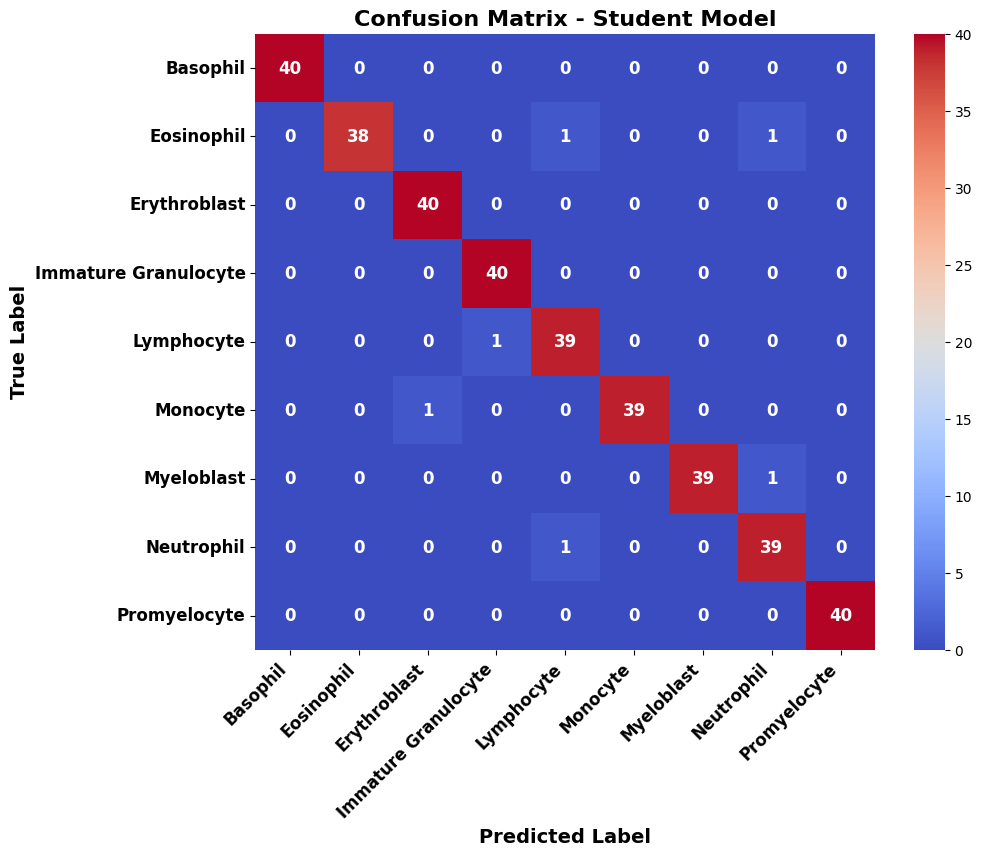

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
class_names = ["Basophil", "Eosinophil", "Erythroblast", "Immature Granulocyte",
               "Lymphocyte", "Monocyte", "Myeloblast", "Neutrophil", "Promyelocyte"]

# Example confusion matrix data (from the second image)
cm = np.array([
    [40, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 38, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 40, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 40, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 39, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 39, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 39, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 39, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 40]
])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontsize": 12, "fontweight": "bold"})  # Bold numbers

# Formatting to match the first image
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.title("Confusion Matrix - Student Model", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.yticks(rotation=0, fontsize=12, fontweight="bold")

# Show the plot
plt.show()


## 🎯 Visualizing Teacher Model Confusion Matrix
We do the same visualization for the **Teacher Model**, allowing side-by-side performance comparison with the student.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
class_names = ["Basophil", "Eosinophil", "Erythroblast", "Immature Granulocyte",
               "Lymphocyte", "Monocyte", "Myeloblast", "Neutrophil", "Promyelocyte"]

# Updated confusion matrix data (from the new image)
cm = np.array([
    [40, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 40, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 40, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 39, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 39, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 39, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 39, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 40, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 39]
])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontsize": 12, "fontweight": "bold"})  # Bold numbers

# Formatting to match the first image
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.title("Confusion Matrix - Teacher Model", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.yticks(rotation=0, fontsize=12, fontweight="bold")

# Show the plot
plt.show()


## 📊 Radial Bar Chart – Comparing Multiple Models
We plot a **stacked radial bar chart** to compare Accuracy, Precision, Recall, and F1-Score of:  
- DenseNet (Random Search)  
- Y-YOLOv10  
- Vision Transformer (ViT)  
- DeepLeuk CNN  
- Proposed MFFA-KD  


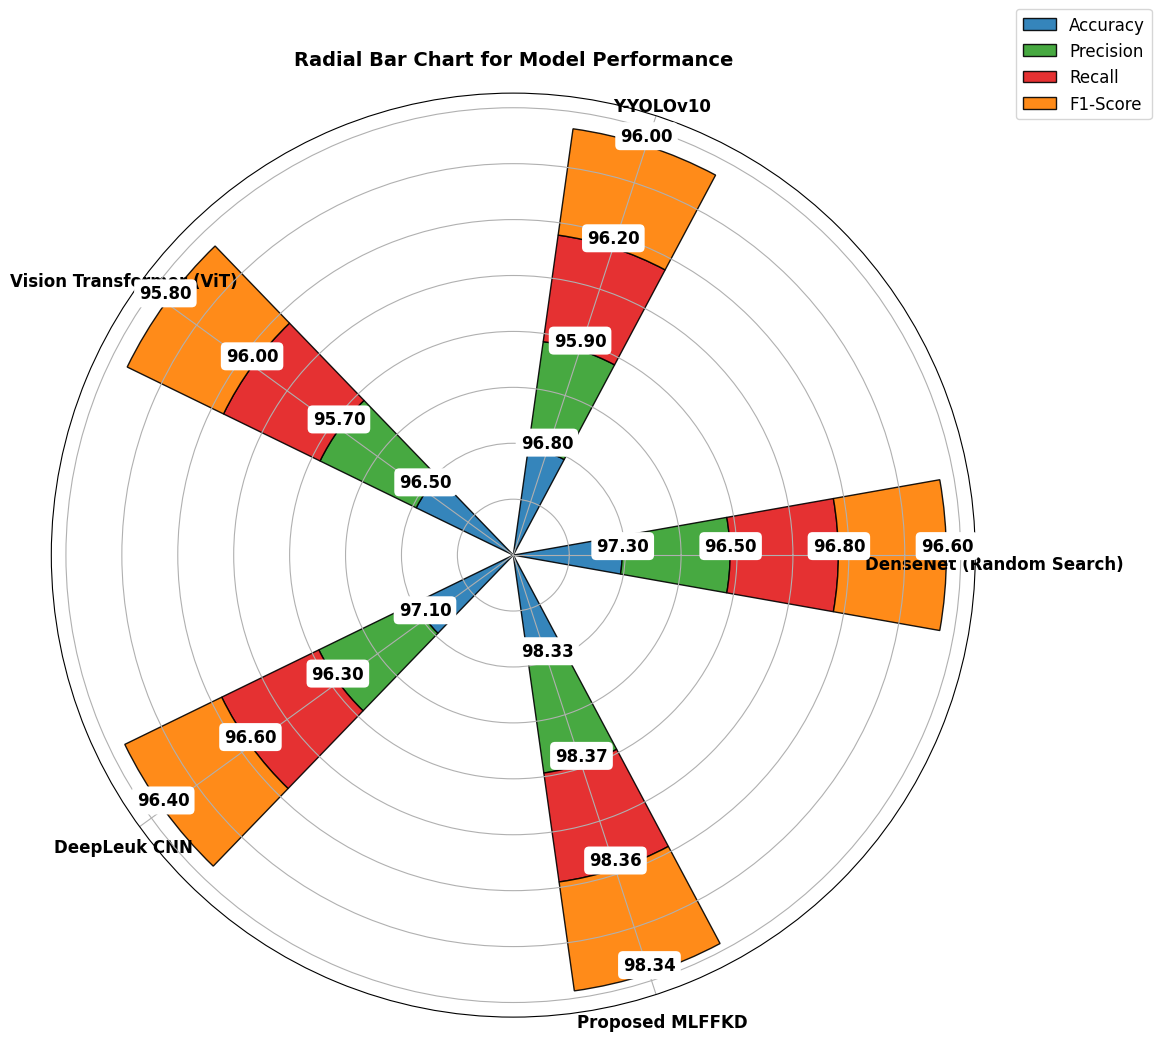

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your model performance table
models = [
    "DenseNet (Random Search)",
    "Y-YOLOv10",
    "Vision Transformer (ViT)",
    "DeepLeuk CNN",
    "Proposed MLFFKD"
]

accuracy = [97.3, 96.8, 96.5, 97.1, 98.33]
precision = [96.5, 95.9, 95.7, 96.3, 98.37]
recall = [96.8, 96.2, 96.0, 96.6, 98.36]
f1_score = [96.6, 96.0, 95.8, 96.4, 98.34]

# Convert data to numpy array for easy stacking
metrics = np.array([accuracy, precision, recall, f1_score])

# Define labels for the metrics
metric_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Choose distinct colors for each metric
colors = ["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00"]

# Calculate angles for each model (equally spaced)
angles = np.linspace(0, 2 * np.pi, len(models), endpoint=False)

# Create a figure with a polar subplot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Plot stacked bars with adjustments to spacing and alignment
bar_width = 0.35  # Reduce width slightly for clarity

for i, (metric, color, label) in enumerate(zip(metrics, colors, metric_labels)):
    bottom_stack = np.sum(metrics[:i], axis=0)  # Sum of previous metrics
    bars = ax.bar(
        angles,              # Position of each bar (angular axis)
        metric,              # Height of the current metric
        width=bar_width,     # Adjust thickness of bars
        bottom=bottom_stack, # Start from the sum of previous bars
        color=color,
        alpha=0.9,
        label=label,
        edgecolor='black'
    )

    # Add values slightly above the bars
    for bar, value, angle in zip(bars, metric, angles):
        height = bar.get_y() + bar.get_height() + 0.5  # Shift text slightly upward
        ax.text(
            angle, height, f"{value:.2f}",
            ha="center", va="bottom", fontsize=12, fontweight="bold", color="black",
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  # Add background for clarity
        )

# Adjust model labels to avoid overlap
ax.set_xticks(angles)
ax.set_xticklabels(models, fontsize=12, fontweight="bold", va='top', rotation=10)

# Hide radial labels
ax.set_yticklabels([])

# Set the title slightly above the plot
ax.set_title("Radial Bar Chart for Model Performance", fontsize=14, fontweight="bold", pad=20)

# Move the legend slightly outside the circle
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=12, frameon=True)

# Show the plot
plt.show()

## 📈 Interactive Bar Chart – Class-wise Performance
We use **Plotly** to create an interactive bar chart showing Precision, Recall, and F1-Score for each class in the dataset.  


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Data extracted from the classification report
classes = [str(i) for i in range(9)]
precision = [1.00, 1.00, 0.98, 0.98, 0.95, 1.00, 1.00, 0.95, 1.00]
recall = [1.00, 0.95, 1.00, 1.00, 0.97, 0.97, 0.97, 0.97, 1.00]
f1_score = [1.00, 0.97, 0.99, 0.99, 0.96, 0.99, 0.99, 0.96, 1.00]

# Create interactive bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=classes, y=precision,
    name='Precision',
    marker_color='blue',
    text=[f"{p:.2f}" for p in precision], textposition='auto'
))

fig.add_trace(go.Bar(
    x=classes, y=recall,
    name='Recall',
    marker_color='green',
    text=[f"{r:.2f}" for r in recall], textposition='auto'
))

fig.add_trace(go.Bar(
    x=classes, y=f1_score,
    name='F1-Score',
    marker_color='red',
    text=[f"{f:.2f}" for f in f1_score], textposition='auto'
))

# Update layout
fig.update_layout(
    title='Classification Report Visualization',
    xaxis_title='Classes',
    yaxis_title='Score',
    barmode='group',
    template='plotly_white',
    legend=dict(title='Metrics')
)

# Show the interactive graph
fig.show()


## 📈 Enhanced Class-wise Performance Visualization
This version includes **actual class names** (Basophil, Eosinophil, etc.) for better interpretability of per-class metrics.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Class names
class_names = ["Basophil", "Eosinophil", "Erythroblast", "Immature Granulocyte",
               "Lymphocyte", "Monocyte", "Myeloblast", "Neutrophil", "Promyelocyte"]

# Classification report values
precision = [1.00, 1.00, 0.98, 0.98, 0.95, 1.00, 1.00, 0.95, 1.00]
recall = [1.00, 0.95, 1.00, 1.00, 0.97, 0.97, 0.97, 0.97, 1.00]
f1_score = [1.00, 0.97, 0.99, 0.99, 0.96, 0.99, 0.99, 0.96, 1.00]

# Create a figure
fig = go.Figure()

# Add bars for Precision, Recall, and F1-Score
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
colors = {'Precision': 'blue', 'Recall': 'green', 'F1-Score': 'red'}

for metric, values in metrics.items():
    fig.add_trace(go.Bar(
        x=class_names,
        y=values,
        name=metric,
        marker=dict(color=colors[metric]),
        text=[f'{v:.2f}' for v in values],
        textposition='outside'
    ))

# Update layout
fig.update_layout(
    title_text="Classification Report of Student Model",
    xaxis_title="Class Names",
    yaxis_title="Scores",
    yaxis=dict(range=[0, 1.1]),
    barmode='group',
    template='plotly_white'
)

# Show figure
fig.show()

## 📊 Teacher Model Performance Summary
We create a simple bar chart showing **Accuracy, Precision, Recall, and F1-Score** for the teacher model.  


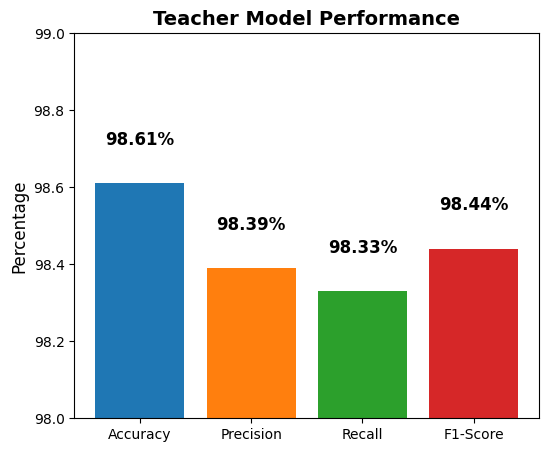

In [ ]:
import matplotlib.pyplot as plt

# Data for Teacher Model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [98.61, 98.39, 98.33, 98.44]

# Create a bar chart
plt.figure(figsize=(6, 5))
plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v}%", ha='center', fontsize=12, fontweight='bold')

# Title and labels
plt.title("Teacher Model Performance", fontsize=14, fontweight='bold')
plt.ylim(98, 99)  # Adjust y-axis limit for better visibility
plt.ylabel("Percentage", fontsize=12)

# Show the plot
plt.show()


## 📊 Student Model Performance Summary
Similar to the teacher, but for the student model – allowing quick performance comparison.  


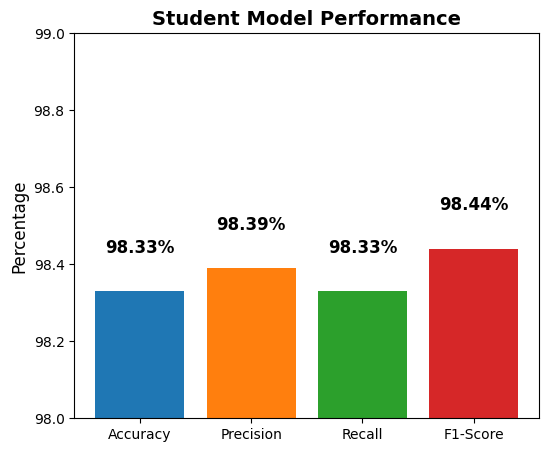

In [ ]:
import matplotlib.pyplot as plt

# Data for Student Model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [98.33, 98.39, 98.33, 98.44]

# Create a bar chart
plt.figure(figsize=(6, 5))
plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v}%", ha='center', fontsize=12, fontweight='bold')

# Title and labels
plt.title("Student Model Performance", fontsize=14, fontweight='bold')
plt.ylim(98, 99)  # Adjust y-axis limit for better visibility
plt.ylabel("Percentage", fontsize=12)

# Show the plot
plt.show()


## 📉 Teacher vs Student – Line Chart
We plot Accuracy, Precision, Recall, and F1-Score for both models on the same graph to visually track differences.  


In [ ]:
import plotly.graph_objects as go

# Data
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
teacher_values = [98.61, 98.39, 98.33, 98.44]
student_values = [98.33, 98.39, 98.33, 98.44]

# Create figure
fig = go.Figure()

# Add Teacher Model Line
fig.add_trace(go.Scatter(x=metrics, y=teacher_values, mode='lines+markers',
                         name='Teacher Model', line=dict(color='blue', width=3),
                         marker=dict(size=10)))

# Add Student Model Line
fig.add_trace(go.Scatter(x=metrics, y=student_values, mode='lines+markers',
                         name='Student Model', line=dict(color='orange', width=3),
                         marker=dict(size=10)))

# Layout
fig.update_layout(title="Performance Comparison of Teacher and Student Models",
                  xaxis_title="Metrics", yaxis_title="Percentage",
                  template="plotly_dark", width=800, height=500)

# Show plot
fig.show()


## 🕸️ Radar Chart – Teacher vs Student
A **spider chart** comparing teacher and student model performances across all metrics for holistic comparison.  


In [ ]:
import plotly.graph_objects as go

# Data
categories = ["Accuracy", "Precision", "Recall", "F1-Score"]
teacher_values = [98.61, 98.39, 98.33, 98.44]
student_values = [98.33, 98.39, 98.33, 98.44]

# Closing the loop for radar chart
teacher_values += [teacher_values[0]]
student_values += [student_values[0]]
categories += [categories[0]]

# Create figure
fig = go.Figure()

# Add Teacher Model
fig.add_trace(go.Scatterpolar(r=teacher_values, theta=categories,
                              fill='toself', name='Teacher Model',
                              line=dict(color="blue")))

# Add Student Model
fig.add_trace(go.Scatterpolar(r=student_values, theta=categories,
                              fill='toself', name='Student Model',
                              line=dict(color="orange")))

# Layout
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),
                  title="Radar Chart: Model Performance Comparison",
                  template="plotly_dark", width=700, height=600)

# Show plot
fig.show()


## 📊 Grouped Bar Chart – Teacher vs Student
We plot a grouped bar chart in **dark theme** for side-by-side metric comparison.  


In [ ]:
import plotly.express as px
import pandas as pd

# Data
df = pd.DataFrame({
    "Metrics": ["Accuracy", "Precision", "Recall", "F1-Score"] * 2,
    "Model": ["Teacher Model"] * 4 + ["Student Model"] * 4,
    "Values": [98.61, 98.39, 98.33, 98.44, 98.33, 98.39, 98.33, 98.44]
})

# Create figure
fig = px.bar(df, x="Metrics", y="Values", color="Model",
             barmode="group", text=df["Values"],
             color_discrete_map={"Teacher Model": "blue", "Student Model": "orange"},
             title="Performance Comparison of Teacher and Student Models")

# Layout improvements
fig.update_traces(texttemplate='%{text:.2f}%', textposition="outside")
fig.update_layout(yaxis_title="Percentage", template="plotly_dark", width=800, height=500)

# Show plot
fig.show()


## 📊 Grouped Bar Chart – Teacher vs Student (White Theme)
Same as before but with a **white background**, making it suitable for reports and publications.  


In [ ]:
import plotly.express as px
import pandas as pd

# Data
df = pd.DataFrame({
    "Metrics": ["Accuracy", "Precision", "Recall", "F1-Score"] * 2,
    "Model": ["Teacher Model"] * 4 + ["Student Model"] * 4,
    "Values": [98.61, 98.39, 98.33, 98.44, 98.33, 98.39, 98.33, 98.44]
})

# Create figure with white background
fig = px.bar(df, x="Metrics", y="Values", color="Model",
             barmode="group", text=df["Values"],
             color_discrete_map={"Teacher Model": "blue", "Student Model": "orange"},
             title="Performance Comparison of Teacher and Student Models")

# Layout improvements
fig.update_traces(texttemplate='%{text:.2f}%', textposition="outside")

# Set white background
fig.update_layout(yaxis_title="Percentage",
                  plot_bgcolor="white",
                  paper_bgcolor="white",
                  width=800, height=500,
                  font=dict(color="black"))

# Show plot
fig.show()
